In [40]:
import sys
import os

import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_tensor, to_pil_image
from torchvision import transforms

sys.path.append(r'/home/declan/Documents/Projects/CS639-FinalProject/src/reconstruction/')
from dataset import FaceDataset
from policy import Policy
from utils import StateObject

### Some test code.

In [9]:
tensor = torch.zeros([32, 3, 512, 512]) # Random input images. batch size=32.
#action_probs = np.random.uniform(low=0, high=1, size=(32, 256)) # Random action probs.
state_object = StateObject(tensor)   # Create the view object.
#state_object.get_views(action_probs) # Get views corresponding to the max prob actions.

#im, pro = state_object.get_view()
#im, pro = torch.Tensor(im), torch.Tensor(pro)

# Policy forward pass
#policy_input = {'im': im, 'pro': pro}

# Test whether the agent works.
agent = Agent()
log_probs, rec_errs, rewards, entropies, decoded, visited_idxes, decoded_all, _ = agent.gather_trajectory(state_object)

#log_probs, rec_errs, rewards, entropies, decoded, values, visited_idxes, decoded_all, _ = agent.gather_trajectory(state, eval_opts=None, pano_maps=pano_maps, opts=opts)
# Backward pass
agent.update_policy(rewards, log_probs, entropies, task_errs=None, values=None)

In [116]:
device = 'cpu'

# Set up the Datasets and the DataLoaders.
transforms_ = transforms.Compose([transforms.Resize(size=(512, 512)), transforms.ToTensor()])
dataset = FaceDataset(transforms=transforms_)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Set up the model and the optimizer.
agent = Agent()
#optimizer = optim.Adam(model.parameters(), lr=.001)

# Begin training model.
n_epochs = 100
for epoch in range(n_epochs):
    epoch_total_loss = 0
    for batch_idx, data in enumerate(data_loader):

        images, _ = data
        
        ### THIS IS A HACKY SOLUTION FOR NOW ### was running into issues with indexing on the final batch where batch_size<32
        if images.shape[0] != 32:
            continue
        
        state_object = StateObject(images)
        log_probs, rec_errs, rewards, entropies, decoded, visited_idxes, decoded_all, _ = agent.gather_trajectory(state_object)
        agent.update_policy(rewards, log_probs, entropies)
        loss = sum(rec_errs)/len(rec_errs)
        epoch_total_loss += loss
        print('BI {} Loss: {:.2f}'.format(batch_idx, loss))
    print('Epoch {} Loss: {:.2f}'.format(epoch, batch_idx, epoch_total_loss.detach().cpu().numpy()))

BI 0 Loss: 0.19
BI 1 Loss: 0.09
BI 2 Loss: 0.06
BI 3 Loss: 0.06
BI 4 Loss: 0.06
BI 5 Loss: 0.06
BI 6 Loss: 0.06
Epoch 0 Loss: 7.00


KeyboardInterrupt: 

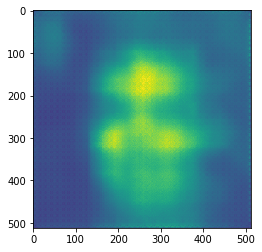

In [124]:
plt.imshow(decoded_all[0][2, 0, :, :].detach().numpy())

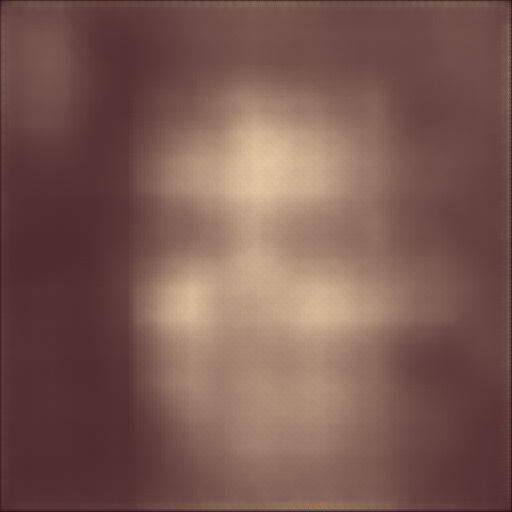

In [122]:
i = 2
img = decoded_all[0][i].detach()
to_pil_image(img)

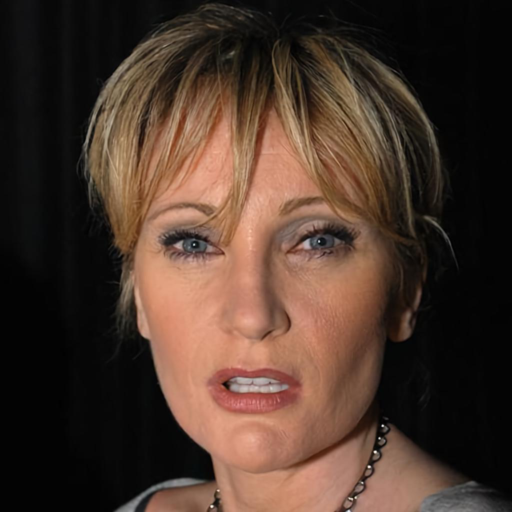

In [123]:
img = images[i].detach()
to_pil_image(img)

In [109]:
class Agent():
    """
    This agent implements the policy from Policy class and uses REINFORCE / Actor-Critic for policy improvement
    """
    def __init__(self):
        super(Agent, self).__init__()
        self.policy = Policy().to(device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=1e-3)
        self.iscuda = False
        
        # Maybe not necessary.
        self.R_avg = 0
        self.avg_count = 0
        self.reward_scale = 1
        self.lambda_entropy = .1
        self.selection_type = 'greedy'


    def gather_trajectory(self, state_object):
        """
        gather_trajectory gets an observation, updates it's belief of the state, decodes the
        panorama and takes the next action. This is done repeatedly for T time steps.
        Note:
        eval_opts are provided only during testing
        """

        # Setup variables to store trajectory information.
        self.T = 25
        rewards = []
        log_probs = []
        rec_errs = []
        entropies = []
        self.avg_count = 0
        hidden = None
        visited_idxes = []
        batch_size = state_object.batch_size
        decoded_all = []
        actions_taken = torch.zeros(batch_size, self.T-1)
        action_probs = None
        
        for t in range(self.T):
            #print('Iteration ', str(t))
            # ---- Observe the panorama ----
            # At first iteration, action probs==None, so state_object returns a fixed view at (0,0).
            
            #if type(action_probs) != type(None):
            #    print(action_probs)
            
            im, pro = state_object.get_view(action_probs)
            im, pro = torch.Tensor(im), torch.Tensor(pro)
            
            # Keep track of visited locations
            visited_idxes.append(state_object.index)

            # ---- Policy forward pass ----
            policy_input = {'im': im, 'pro': pro}
            
            # Update if using CUDA.
            if self.iscuda:
                for var in policy_input:
                    policy_input[var] = policy_input[var].cuda()
            
            # Otherwise use the CPU.
            else:
                for var in policy_input:
                    policy_input[var] = Variable(policy_input[var])

            # Note: decoded and hidden correspond to the previous transition
            # probs and value correspond to the new transition, where the value
            # and action probabilities of the current state are estimated for PG update.
            action_probs, hidden, decoded = self.policy.forward(policy_input, hidden)
            decoded_all.append(decoded)

            # Compute reconstruction loss (corresponding to the previous transition).
            ###### NOTE: MAY BE APPROPRIATE TO USE A DIFFERENT LOSS FUNCTION HERE.
            rec_err = F.mse_loss(decoded, state_object.images.to(device))
            self.optimizer.zero_grad()
            #nn.utils.clip_grad_norm_(self.policy.parameters(), 10)
            rec_err.backward(retain_graph=True)
            self.optimizer.step()
            # 

            # Reconstruction reward is obtained only at the final step
            # If there is only one step (T=1), then do not provide rewards
            # Note: This reward corresponds to the previous action
            if t == 0:
                reward = torch.zeros(batch_size)
                if self.iscuda:
                    reward = reward.cuda()
            ##### I HAVE NO IDEA WHAT'S GOING ON HERE. #####
            else:
                reward = -rec_err.data # Disconnects reward from future updates
                self.R_avg = (self.R_avg * self.avg_count + reward.sum())/(self.avg_count + batch_size)
                self.avg_count += batch_size
            if t > 0:
                rewards[t-1] += reward
                
            # There are self.T reconstruction errors as opposed to self.T-1 rewards
            rec_errs.append(rec_err)

            # Sample action except for the last time step when only the selected view from previous step is used in aggregate.
            if t < self.T - 1:
                # Act based on the policy network
                if self.selection_type != 'greedy':
                    act = action_probs.multinomial(num_samples=1).data
                else:
                    # This works only while evaluating, not while training
                    _, act = action_probs.max(dim=1)
                    act = act.data.view(-1, 1)
                
                # Compute entropy
                entropy = -(action_probs*((action_probs+1e-7).log())).sum(dim=1)
                # Store log probabilities of selected actions (Advanced indexing).
                log_prob = (action_probs[range(act.size(0)), act[:, 0]]+1e-7).log() # Save log_probs of choosing selected actions.

                # This is the intrinsic reward corresponding to the current action
                #### NOTE: COULD BE WRONG.
                rewards.append(reward)
                log_probs.append(log_prob)
                entropies.append(entropy)

        return log_probs, rec_errs, rewards, entropies, decoded, visited_idxes, decoded_all, actions_taken
    
    
    def update_policy(self, rewards, log_probs, entropies, task_errs=None, values=None):
        """
        This function will take the rewards, log probabilities and task-specific errors from
        the trajectory and perform the parameter updates for the policy using REINFORCE.
        INPUTS:
            rewards: list of T-1 Tensors containing reward for each batch at each time step.
            log_probs: list of T-1 logprobs Variables of each transition of batch.
            task_errs: list of T error Variables for each transition of batch.
            entropies: list of T-1 entropy Variables for each transition of batch.
            values: list of T-1 predicted values Variables for each transition of batch.
        """
        # ---- Setup initial values ----
        batch_size = rewards[0].size(0)
        R = torch.zeros(batch_size) # Reward accumulator
        B = 0 # Baseline accumulator - used primarily for the average baseline case
        loss = Variable(torch.Tensor([0]))
        if self.iscuda:
            loss = loss.cuda()
            R = R.cuda()
    
        # Task-specific error computation
        #for t in reversed(range(self.T)):
        #    loss = loss + task_errs[t].sum()/batch_size
    
        # REINFORCE loss based on T-1 transitions.
        # Note: This will automatically be ignored when self.T = 1
        for t in reversed(range(self.T-1)):
            R = R + rewards[t] # A one sample MC estimate of Q[t]
            # PG loss
            loss_term_1 = -(log_probs[t]*self.reward_scale).sum()/batch_size # Removed adv... Not sure what that does. 
            # Entropy loss, maximize entropy
            #loss_term_2 = -self.lambda_entropy*entropies[t].sum()/batch_size
            loss = loss + loss_term_1 #+ loss_term_2
    
        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.policy.parameters(), 10)
        self.optimizer.step()

### Now try to create a reasonable algorithm.

In [ ]:
def reinforce(env, policy_estimator, num_episodes=10, batch_size=10, gamma=0.99):    # Set up lists to hold results
    total_rewards = []
    batch_rewards = []
    batch_actions = []
    batch_states = []
    batch_counter = 1
    
    # Define optimizer
    optimizer = optim.Adam(policy_estimator.network.parameters(), lr=0.01)
    
    action_space = np.arange(env.action_space.n)
    ep = 0
    while ep < num_episodes:
        s_0 = env.reset()
        states = []
        rewards = []
        actions = []
        done = False
        while done == False:
            # Get actions and convert to numpy array
            action_probs = policy_estimator.predict(s_0).detach().numpy()
            action = np.random.choice(action_space, p=action_probs)
            s_1, r, done, _ = env.step(action)
            states.append(s_0)
            rewards.append(r)
            actions.append(action)
            s_0 = s_1
            
            # If done, batch data
            if done:
                batch_rewards.extend(discount_rewards(rewards, gamma))
                batch_states.extend(states)
                batch_actions.extend(actions)
                batch_counter += 1
                total_rewards.append(sum(rewards))
                
                # If batch is complete, update network
                if batch_counter == batch_size:
                    optimizer.zero_grad()
                    state_tensor = torch.FloatTensor(batch_states)
                    reward_tensor = torch.FloatTensor(batch_rewards)
                    # Actions are used as indices, must be LongTensor
                    action_tensor = torch.LongTensor(batch_actions)
                    
                    # Calculate loss
                    logprob = torch.log(policy_estimator.predict(state_tensor))
                    selected_logprobs = reward_tensor * torch.gather(logprob, 1, action_tensor).squeeze()
                    loss = -selected_logprobs.mean()
                    
                    # Calculate gradients
                    loss.backward()
                    # Apply gradients
                    optimizer.step()
                    
                    batch_rewards = []
                    batch_actions = []
                    batch_states = []
                    batch_counter = 1
                    
                avg_rewards = np.mean(total_rewards[-100:])
                # Print running average
                print("\rEp: {} Average of last 100:" + "{:.2f}".format(ep + 1, avg_rewards), end="")
                ep += 1
                
    return total_rewards